# Accelerated single-cell clustering with Rapids

In [ ]:
%%capture # requirements
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu11==24.10.* dask-cudf-cu11==24.10.* cuml-cu11==24.10.* \
    cugraph-cu11==24.10.* nx-cugraph-cu11==24.10.* cuspatial-cu11==24.10.* \
    cuproj-cu11==24.10.* cuxfilter-cu11==24.10.* cucim-cu11==24.10.* \
    pylibraft-cu11==24.10.* raft-dask-cu11==24.10.* cuvs-cu11==24.10.* \
    nx-cugraph-cu11==24.10.*
!pip install rapids-singlecell

In [17]:
%%capture # imports
import rapids_singlecell as rsc
from matplotlib import pyplot as plt
import pandas as pd
import scanpy as sc
import anndata as ad
import timeit

In [86]:
adata = ad.read_h5ad('single_sample_features/cell_centered_embeddings/mel01_3_1_embeddings_all.h5ad') # read data
# cell_type = Manual gating, # cell_type_updated = Auto gating

In [87]:
clean_adata = adata[adata.obs['cell_type']!='unknown'].copy() # remove unknown and multiple cell types
clean_adata = clean_adata[clean_adata.obs['cell_type']!='multiple'].copy()

In [ ]:
rsc.get.anndata_to_GPU(clean_adata) # data to GPU

In [88]:
rsc.pp.neighbors(clean_adata) # kNN graph

In [89]:
start = timeit.default_timer() # fast Louvain clustering!
rsc.tl.louvain(clean_adata,resolution=0.1)
stop = timeit.default_timer()
print(f'time: {stop-start}')

time: 2.253013769000063


In [90]:
rsc.tl.umap(clean_adata)

In [91]:
rsc.get.anndata_to_CPU(clean_adata)

In [92]:
d = clean_adata.copy()

In [102]:
# custom cmap
manual_colors = [
    "#E69F00",  # orange
    "#56B4E9",  # light blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # dark blue
    "#D55E00",  # reddish-orange
    "#CC79A7",  # pink
    "#882255",  # dark magenta (added color for 9th class)
]

auto_colors = [
    "#56B4E9",  # light blue
    "#009E73",  # green
    "#F0E442",  # yellow
    "#0072B2",  # dark blue
    "#D55E00",  # reddish-orange
    "#CC79A7",  # pink
    "#882255",  # dark magenta (added color for 9th class)
]

## Plot cell types and embedding clusters on UMAP from embeddings

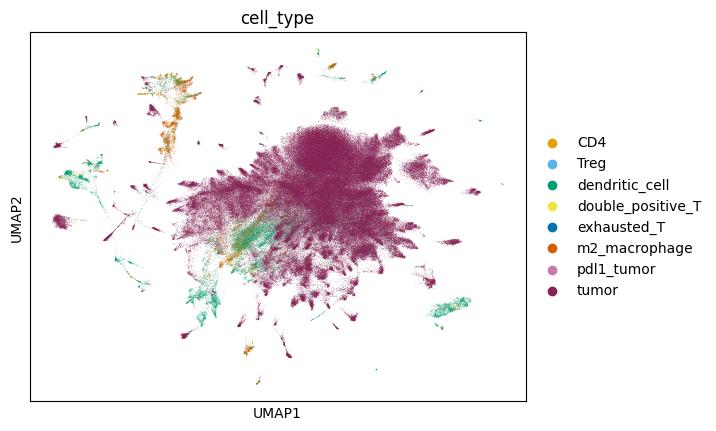

In [99]:
sc.pl.umap(d, color='cell_type', palette=colors)

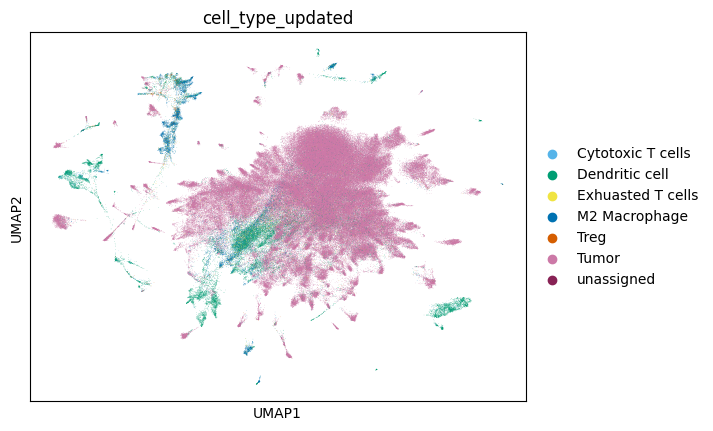

In [103]:
sc.pl.umap(d, color='cell_type_updated', palette=auto_colors)

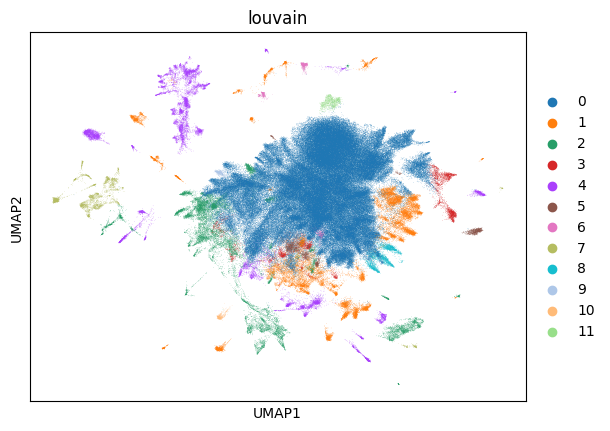

In [50]:
sc.pl.umap(d, color='louvain')

## Plot embedding clusters on original image

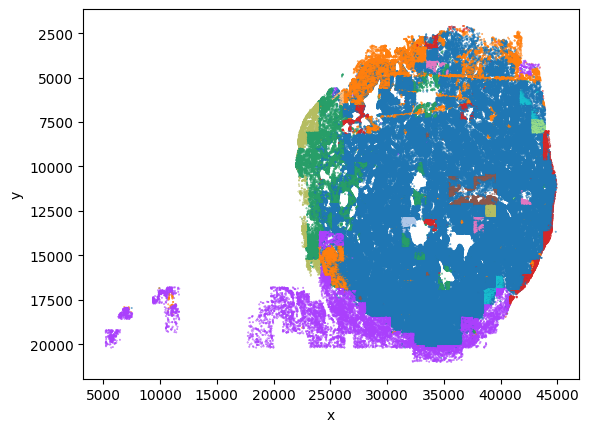

In [57]:
x, y = clean_adata.obs['patch_centroids_row_orig'], clean_adata.obs['patch_centroids_col_orig']
color_list = d.uns['louvain_colors']
c = [color_list[k] for k in list(d.obs['louvain'].astype(int))]
plt.scatter(y,x,s=0.1,c=c)
plt.gca().invert_yaxis()
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(None)
plt.yticks(None)
plt.show()